# COVID Global Forecast: SIR model

In the context of the global COVID-19 pandemic, Kaggle has launched several challenges in order to provide useful insights that may answer some of the open scientific questions about the virus. This is the case of the [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-1), in which participants are encouraged to fit worldwide data in order to predict the pandemic evolution, hopefully helping to determine factors that impact the transmission rate of COVID-19.

**TABLE OF CONTENTS**

1. [Exploratory data analysis (EDA)](#section1)
2. [SIR model](#section2)
3. [Data enrichment](#section3)
4. [Predictions with machine learning](#section4)

**Disclaimer**: this notebook is still under construction. In fact, the last subsection is not correct. I'll work to fix it in the following days, as long as expand the methods to predict the COVID-19 evolution.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# 1. Exploratory data analysis (EDA) <a id="section1"></a>

First of all, let's take a look on the data structure:

In [ ]:
#submission = pd.read_csv("../input/covid19-global-forecasting-week-1/submission.csv")
test = pd.read_csv("/media/pion-02/commons/extra/covid/covid19-global-forecasting-week-1/test.csv")
train = pd.read_csv("/media/pion-02/commons/extra/covid/covid19-global-forecasting-week-1/train.csv")
display(train.head(5))
display(train.describe())
print("Number of Country/Region: ", train['Country/Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")

In [ ]:
#confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

## 1.1. COVID-19 global tendency excluding China

Since details of the initial breakthrough strongly interfere with the results, it's recomended to analyze China independently. Let's first see the results without China: 

In [ ]:
#confirmed_country_noChina = train[train['Country/Region']!='China'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_noChina = train[train['Country/Region']!='China'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_noChina = train[train['Country/Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country/Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**: In this case the general behavior looks cleaner, and in fact the curve resembles a typical epidemiology model like [SIR](http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf). SIR models present a large increasing in the number of infections that, once it reaches the maximum of the contagion, decreases with a lower slope. For comparison, a SIR simulation from section [2. SIR model](#section2):

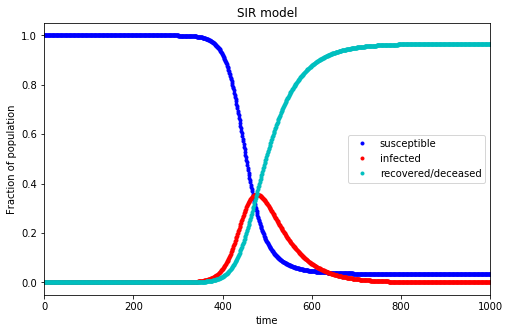

## 1.2. COVID-19 tendency in China

Since China was the initial infected country, the COVID-19 behavior is different from the rest of the world. The medical system was not prepared for the pandemic, in fact no one was aware of the virus until several cases were reported. Moreover, China government took strong contention measures in a considerable short period of time and, while the virus is widely spread, they have been able to control the increasing of the infections. 

In [ ]:
#confirmed_country_China = train[train['Country/Region']=='China'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_China = train[train['Country/Region']=='China'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_China = train[train['Country/Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country/Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**:

* **Smoothness**. Both plots are less smooth than theoretical simulations or the curve from the rest of the world cumulative
* **Infected criteria**. The moment in which the criteria to consider an infected case was changed is direclty spotted
* **Irregularities**. There are some iregularities. I should check the literature in depth to look for evidences, but the reasons may be that both the resources spent to monitor the epidemy and the security measures to stop ot have been changing over time
* **Plateaux**. It looks like the curve has reached a plateaux, which would imply that China is on their maximum of contagion 

## 1.3. Italy, Spain, UK and Singapore

Both Italy and Spain are experiencing the larger increase in COVID-19 positives in Europe. At the same time, UK is a unique case given that it's one of the most important countries in Europe but recently has left the European Union, which has create an effective barrier to human mobility from other countries. The fourth country we will study in this section is Singapore, since it's an asiatic island, is closer to China and its  socio-economic conditions is different from the other three countries.

In [ ]:
#confirmed_country_Italy = train[train['Country/Region']=='Italy'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[train['Country/Region']=='Italy'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[train['Country/Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country/Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[train['Country/Region']=='Spain'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[train['Country/Region']=='Spain'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[train['Country/Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country/Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[train['Country/Region']=='Australia'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[train['Country/Region']=='Australia'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[train['Country/Region']=='Australia'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[train['Country/Region']=='Australia'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(2, 2, 3)
total_date_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Singapore.plot(ax=plt.gca(), title='Singapore')

In [ ]:
confirmed_total_date_India = train[train['Country/Region']=='India'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_India = train[train['Country/Region']=='India'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_India = confirmed_total_date_India.join(fatalities_total_date_India)

total_date_India.plot(ax=plt.gca(), title='India')

In [ ]:
pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.
pop_india = 13392000

total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_Singapore.ConfirmedCases = total_date_Singapore.ConfirmedCases/pop_singapore*100.
total_date_Singapore.Fatalities = total_date_Singapore.ConfirmedCases/pop_singapore*100.
total_date_India.ConfirmedCases = total_date_India.ConfirmedCases/pop_india*100.
total_date_India.Fatalities = total_date_India.ConfirmedCases/pop_india*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.06)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.06)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.005)

plt.subplot(2, 2, 4)
total_date_Singapore.ConfirmedCases.plot(ax=plt.gca(), title='Singapore')
plt.ylim(0, 0.005)

In [ ]:
total_date_India.ConfirmedCases.plot(ax=plt.gca(), title='India')

In order to compare the 4 countries, it's also interesting to see the evolution of the infections from the first confirmed case:

In [ ]:
#confirmed_country_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

confirmed_total_date_India = train[(train['Country/Region']=='India') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_India = train[(train['Country/Region']=='India') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_India = confirmed_total_date_India.join(fatalities_total_date_India)

italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:50] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:50] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:50] 
singapore = [i for i in total_date_Singapore.ConfirmedCases['sum'].values]
singapore_30 = singapore[0:50] 

india = [i for i in total_date_India.ConfirmedCases['sum'].values]
india_30 = india[0:50] 


# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(singapore_30)
plt.plot(india_30)
plt.legend(["Italy", "Spain", "UK", "Singapore","India"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 60000)
plt.show()

# 2. SIR model <a id="section2"></a>

We have seen some general behavior of the virus in agregated data, for the country where the coronavirus was originated and for four other interesting countries. There's a lot of information to be extracted from this data; for example, we haven't analyzed the effects of long/lat of countries. However, since our main purpose is to develop a predective model in order to understand the key factors that impact the COVID-19 transmission, I'll move on to one of the most famous epidemiologic models: SIR. 

SIR is a simple model that considers a population that belongs to one of the following states:
1. **Susceptible (S)**. The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people
2. **Infected (I)**. This person has contracted the disease
3. **Recovered/Deceased (R)**. The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased. 

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki from [lewuathe.com](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)

There are many versions of this model, considering birth and death (SIRD with demography), with intermediate states, etc. However, since we are in the early stages of the COVID-19 expansion and our interest is focused in the short term, we will consider that people develops inmunity (in the long term, inmunity may be lost and the COVID-19 may come back within a certain seasonality like the common flu). Hence, the differential equations that govern the system are:
$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

Focusing in the short term, individuals develop inmunity to the virus, which effectively denies any transition between recovered people and susceptible one (i.e. once you have passed the virus, you can not be contagied again). Of course, this may be different in the long term, and the virus may come back within a certain seasonality like the common flu.

## 2.1. Implementing the SIR model

SIR model can be implemented in many ways: from the differential equations governing the system, within a mean field approximation or running the dynamics in a social network (graph). FOr the sake of simplicity, I'vem chosen the first option, and we will simply run a numerical method (Runge-Kutta) to solve the differential equations system. 

The functions governing the dif.eqs. are:

In [ ]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In order to solve the differential equations system, we develop a [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) method of 4rth order:

In [ ]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

And finally, to obtain the evolution of the disease we simply define the initial conditions and call the rk4 method:

In [ ]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

Results obtained for N=world population, only one initial infected case, $\beta=0.3$, $\gamma=0.5$ and a leap pass $h_s = 0.1$ are shown below:

In [ ]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

**Observations**: 
* The number of infected cases increases for a certain time period, and then eventually decreases given that individuals recover/decease from the disease
* The susceptible fraction of population decreases as the virus is transmited, to eventually drop to the absorbent state 0
* The oposite happens for the recovered/deceased case

Notice that different initial conditions and parameter values will lead to other scenarios, feel free to play with these numbers to study the system.

## 2.2. Fit SIR parameters to real data

The SIR model is purely theoretical, and we are interested into a real approximation of the COVID-19 expansion in order to extract insights and understand the transmission of the virus. Hence, we need to extract the $\beta$ and $\gamma$ paramaters for each case if we hope to be able to predict the evolution of the system.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

population = float(pop_india)
country_df = total_date_Italy[9:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases['sum'].values]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

Clearly **this fit of parameters is not correct**, since we are expecting both $\beta$ and $\gamma$ factors to be <1. I'll keep working on the error for curiosity, but in the meanwhile I'll develop a data-centric approach to the prediction.

# 3. Data enrichment <a id="section3"></a>

Analyzing SIR simulations was meant to understand a model that approximately resembles the transmission mechanism of many virus, including the COVID-19. However, there are alternative methods that may prove being equally useful both to predict and to understand the pandemic evolution. Many of these methods rely on having rich data to extract conclusions and allow algorithms to extrapolate patterns in data, and that is exactly what we are going to do. 

Main workflow of this section:
1. Join data, filter dates and clean missings
2. Compute lags and trends
3. Add country details

**Disclaimer**: this data enrichment is not mandatory and we could end up not using all of the new features in our models. However I consider it a didactical step that will surely add some value, for example in an in-depth exploratory analysis.

## 3.1. Join data, filter dates and clean missings

First of all, we perform some pre-processing prepare the dataset, consisting on:

* **Join data**. Join train/test to facilitate data transformations
* **Filter dates**. According to the challenge conditions, remove ConfirmedCases and Fatalities post 2020-03-12. Create additional date columns
* **Missings**. Analyze and fix missing values

In [ ]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18','2020-03-19','2020-03-20','2020-03-21','2020-03-22']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-12', 'ConfirmedCases'] = np.nan
all_data.loc[all_data['Date'] >= '2020-03-12', 'Fatalities'] = np.nan
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province/State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

# Aruba has no Lat nor Long. Inform it manually
all_data.loc[all_data['Lat'].isna()==True, 'Lat'] = 12.510052
all_data.loc[all_data['Long'].isna()==True, 'Long'] = -70.009354

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-03-12'])

**Observations**: 
* "ConfirmedCases" and "Fatalities" are now only informed for dates previous to 2020-03-12
* The dataset includes all countries and dates, which is required for the lag/trend step
* Missing values for "ConfirmedCases" and "Fatalities" have been replaced by 0, which may be dangerous if we do not remember it at the end of the process. However, since we will train only on dates previous to 2020-03-12, this won't impact our prediction algorithm
* A new column "Day" has been created, as a day counter starting from the first date

Double-check that there are no remaining missing values:

In [ ]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

## 3.2. Compute lags and trends

Enriching a dataset is key to obtain good results. In this case we will apply 2 different transformations:

**Lag**. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
$$X_{lag3}(t) = X(t-3)$$


**Trend**. Transformig a column into its trend gives the natural tendency of this column, which is different from the raw value. The definition of trend I will apply is: 
$$Trend_{X} = {X(t) - X(t-1) \over X(t-1)}$$

The backlog of lags I'll apply is 14 days, while for trends is 7 days.  For ConfirmedCases and Fatalities:

In [ ]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df


ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, [1], 'ConfirmedCases')
all_data = calculate_trend(all_data, [1], 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

As you see, the process is really fast. An example of some of the lag/trend columns for Spain:

In [ ]:
all_data[all_data['Country/Region']=='India'].iloc[40:50][['Id', 'Province/State', 'Country/Region', 'Lat', 'Long', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

## 3.3. Add country details

Variables like the total population of a country, the average age of citizens or the fraction of peoople living in cities may strongly impact on the COVID-19 transmission behavior. Hence, it's important to consider these factors. I'm using [Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020) based on Web Scrapping for this purpose.

In [ ]:
# Load countries data file
world_population = pd.read_csv("/media/pion-02/commons/extra/covid/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country/Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country/Region'] = le.fit_transform(all_data['Country/Region'])
number_c = all_data['Country/Region']
countries = le.inverse_transform(all_data['Country/Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province/State'] = le.fit_transform(all_data['Province/State'])
number_p = all_data['Province/State']
province = le.inverse_transform(all_data['Province/State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

# 4. Predictions with machine learning <a id="section4"></a>

Our obective in this section consists on  predicting the evolution of the expansion from a data-centric perspective, like any other regression problem. To do so, remember that the challenge specifies that submissions on the public LB shouldn only contain data previous to 2020-03-12.

Models to apply:
1. Basic Linear regression

## 4.1. Basic Linear Regression

Since we are interested into predicting the future time evolution of the pandemic, our first approach consists on a simple Linear Regression. However, remind that the evolution is not linear but exponential (only in the beginning of the infection), so that a preliminar log transformation is needed. 

Visual comparison of both cases for Spain and with data from last 10 days informed, starting on March 1st:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Lat']==40.0) & (all_data['Long']==-4.0) & (all_data['Day_num']>38) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("India ConfirmedCases between days 38 and 49 (last 10 days)")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Lat']==40.0) & (all_data['Long']==-4.0) & (all_data['Day_num']>38) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("India Log ConfirmedCases between days 38 and 49 (last 10 days))")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

As you see, the log transformation results in a fancy straight-like line, which is awesome for Linear Regression. However, let me clarify two important points:

* This "roughly exponential behavior" is only true for the initial infection stages of the pandemic (the initial increasing of infections on the SIR model), but that's exactly the point where most countries are at the moment.

* Why do I only extract the last 10 days of data? For three reasons:
    1. In order to capture exactly the very short term component of the evolution
    2. To prevent the effects of certain variables that have been impacting the transmition speed (quarantine vs free circulation)
    3. To prevent differences on criteria when confirming cases (remember that weird slope on the China plot?)

This first model is very simple, and only elemental features will be considered: Country/Region, date information, Long and Lat. Lags. Engineered columns like lags, trends and country details are not introduced as an input. Finally, the workflow for the Basic Linear Regression model is:
1. **Features**. Select features
2. **Dates**. Filter train data from 2020-03-01 to 2020-03-11
2. **Log transformation**. Apply log transformation to ConfirmedCases and Fatalities
3. **Infinites**. Replace infinites from the logarithm
4. **Train/test split**. Split into train/valid/test
5. **Prediction**. Linear Regression, training country by country and joining data
6. **Submit**. Submit results in the correct format, and applying exponential to reverse log transformation 

In [ ]:
from xgboost import XGBClassifier

ts = time.time()

# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country/Region', 'Province/State', 'ConfirmedCases', 'Fatalities', 
       'Day_num', 'Day', 'Month', 'Year', 'Long', 'Lat']
data = data[features]

# Keep data from February 27th to March 12th. Remember that data from 2020-03-12 to 2020-03-22 was cleaned from train dataset
data = data[(data.Day_num>=38)]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(data):
    
    # Train set
    x_train = data[data.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data[data.ForecastId == -1]['ConfirmedCases']
    y_train_2 = data[data.ForecastId == -1]['Fatalities']

    # Test set
    x_test = data[data.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    index = x_test['ForecastId'].astype('int32')
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test, index


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = XGBClassifier()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(index, df):
    
    prediction_1 = data_pred['Predicted_ConfirmedCases']
    prediction_2 = data_pred['Predicted_Fatalities']

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

    
# Set the dataframe where we will update the predictions
data_pred = data[data.ForecastId != -1][['Country/Region', 'Province/State', 'Day_num', 'ForecastId']]
data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
data_pred['Predicted_Fatalities'] = [0]*len(data_pred)
    
print("Currently running Logistic Regression for all countries")

for c in data['Country/Region'].unique():
    
    # If the country has several Province/State informed
    if data[data['Country/Region']==c]['Province/State'].nunique()>1:
        continue
        
    # No Province/State informed
    else:
        data_c = data[(data['Country/Region']==c)]
        X_train, Y_train_1, Y_train_2, X_test, index = split_data(data_c)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data_pred.loc[(data_pred['Country/Region']==c), 'Predicted_ConfirmedCases'] = pred_1
        data_pred.loc[(data_pred['Country/Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.exp(x))
data_pred.replace([np.inf, -np.inf], 0, inplace=True) 

get_submission(index, data_pred)

print("Process finished in ", round(time.time() - ts, 2), " seconds")

And that's it, our results have been submited. Nonetheless, since I like reviewing the model's predictions, let me analyze the results when training the model for a single country (in this case Spain):

In [ ]:
# Filter India, run the Linear Regression workflow

data_India = data[data['Country/Region']==country_dict['India']]
X_train, Y_train_1, Y_train_2, X_test, index = split_data(data_India)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 22nd
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(39, 61))))].Target

# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22']

real_data = train.loc[(train['Country/Region']=='India') & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle("India's ConfirmedCases predictions based on Logistic Regression")

**Observations**:

* Results are quite good; the evolution is well captured despite the simplicity of the model
* With 10 days to train, predictions for the following 5 days are really accurate
* The estimations are increasingly worse as time passes

In [ ]:
# ALTERNATIVE FUNCTIONS FOR FURTHER ANALYSIS

# LGB Regressor 
"""
model=lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        #min_child_weight=300,
        #num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=16,
        #reg_alpha=0.04,
        #reg_lambda=0.073,
        #min_split_gain=0.0222415,
        verbose=1,
        seed=21)

model.fit(X_train, Y_train_1, eval_metric="rmse", eval_set=[(X_train, Y_train_1), (X_valid, Y_valid_1)], verbose=1, early_stopping_rounds = 20)

Y_test = model.predict(X_test)
"""


# Show India enriched data
"""
data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']==49)]
train[(train['Country/Region']=='Spain') & (train['Date']=='2020-03-12')]
data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']==49)]['ConfirmedCases'].apply(lambda x: np.exp(x))
"""


# XGB Regressor
"""
reg = xgb.XGBRegressor()
reg.fit(X_train, Y_train_1,
        eval_set=[(X_train, Y_train_1), (X_valid, Y_valid_1)],
        early_stopping_rounds=50,
       verbose=True)

_ = plot_importance(reg, height=0.9, max_num_features=20)
Y_pred = reg.predict(X_valid)
print(Y_pred)
"""


# XGB GridSearch
"""
ts = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.07, .01, .005], #so called `eta` value
              'max_depth': [4, 5, 6, 7],
              'min_child_weight': [4, 5, 6, 7],
              'silent': [0],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, Y_train_1)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Y_pred = xgb_grid.predict(X_valid)
print(Y_pred, Y_valid_1)

print("Time spent: ", ts-time.time())
"""


# Some plots
"""
plt.plot(data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']<=49)]['ConfirmedCases'])

y = data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']> 35) & (data['Day']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x = range(0, len(y))
plt.plot(x, y, 'go--')
"""


# Linear Regression
"""
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train_1)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Compute mean squared error on real values (inverse transform of log)
#rms = mean_squared_error(Y_test_1.apply(lambda x: np.exp(x)).astype('int16'), np.exp(y_pred).astype('int16'))
#print("Mean squared error: ", rms)
"""

# LGB 2
"""
def xgb_reg(X_train, Y_train_1, X_test):
    # Create linear regression object
    regr = lgb.LGBMRegressor(n_estimators=1000)

    # Train the model using the training sets
    regr.fit(X_train, Y_train_1, eval_metric="rmse")

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # Compute mean squared error on real values (inverse transform of log)
    #rms = mean_squared_error(Y_test_1.apply(lambda x: np.exp(x)).astype('int16'), np.exp(y_pred).astype('int16'))
    #print("Mean squared error: ", rms)
    
    return regr, y_pred
"""

In [ ]:
"""
#Predictions
X_test_compare = X_test.copy()
X_test_compare['PredictedCases'] = y_pred_xgb
X_test_compare.loc[(X_test_compare['Day']>=50) & (X_test_compare['Day']<73)]

# Train test
compare = train.loc[train['Date'].isin(dates_overlap)]
compare = compare.merge(test[['Country/Region', 'Date', 'ForecastId']], on=['Country/Region', 'Date'])
#compare['PredictedCases'] = X_test_compare.loc[(X_test_compare['Day']>=50) & (X_test_compare['Day']<73), 'PredictedCases']
compare

# Total comparison
total_compare = X_test_compare.join(compare, on='ForecastId', rsuffix='X_compare')
total_compare[['ForecastId', 'Country/Region', 'ConfirmedCases', 'PredictedCases']]
"""